#Netflix Titles - Exploratory Data Analysis (EDA)

**Author:** Vivek Kamra
**Project:** Netflix-EDA-Project
**Notebook:** netflix_eda.ipynb

This notebook performs an end-to-end exploratory data analysis of the Netflix Movies & TV Shows using Pandas, NumPy, Matplotlib and Seaborn. It contains data loading, cleaning, feature analysis, statistics, visualizations and insights.

In [1]:
#Core libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Notebook settings
%matplotlib inline
sns.set(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (10, 5)

#Create images folder if not exists
os.makedirs("../images", exist_ok=True) #if notebook in notebooks/, images in repo root/images
#if notebook folder is repo root (notebooks/), chane path to "./images"

## 1. Load dataset

In [2]:
csv_path = "../data/netflix_titles.csv" #if notebook in notebooks/

df = pd.read_csv(csv_path)
print("Shape:", df.shape)
df.head()

Shape: (8807, 12)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


### Quick dataset info
- Show columns, dtypes, and null counts.

In [3]:
df.info()
print("\nNull counts:\n", df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB

Null counts:
 show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
descri

## 2. Initial Cleaning Plan
- Convert 'date_added' to datetime.
- Standardize 'country' and 'rating' missing values.
- Remove exact duplicates.
- Create safe copy for analysis.

In [4]:
#create copy
clean_df = df.copy()

#date_added -> datetime
clean_df["date_added"] = pd.to_datetime(clean_df["date_added"], errors='coerce')

#Fill country and rating missing values
clean_df["country"] = clean_df["country"].fillna("unknown")
clean_df["rating"] = clean_df["rating"].fillna("Not Rated")

#Drop duplicates (if any)
before = clean_df.shape[0]
clean_df = clean_df.drop_duplicates()
after = clean_df.shape[0]
print(f"Dropped {before-after} duplicate rows")

#Strip whitespace from string columns
str_cols = clean_df.select_dtypes(include="object").columns
for c in str_cols:
    clean_df[c] = clean_df[c].str.strip()

clean_df.reset_index(drop=True, inplace=True)
clean_df.info()

Dropped 0 duplicate rows
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   show_id       8807 non-null   object        
 1   type          8807 non-null   object        
 2   title         8807 non-null   object        
 3   director      6173 non-null   object        
 4   cast          7982 non-null   object        
 5   country       8807 non-null   object        
 6   date_added    8709 non-null   datetime64[ns]
 7   release_year  8807 non-null   int64         
 8   rating        8807 non-null   object        
 9   duration      8804 non-null   object        
 10  listed_in     8807 non-null   object        
 11  description   8807 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(10)
memory usage: 825.8+ KB


## 3. Content Type Distribution (Movie vs TV Show)

In [5]:
type_counts = clean_df["type"].value_counts()
type_counts, (type_counts / len(clean_df) * 100).round(2)

(type
 Movie      6131
 TV Show    2676
 Name: count, dtype: int64,
 type
 Movie      69.62
 TV Show    30.38
 Name: count, dtype: float64)

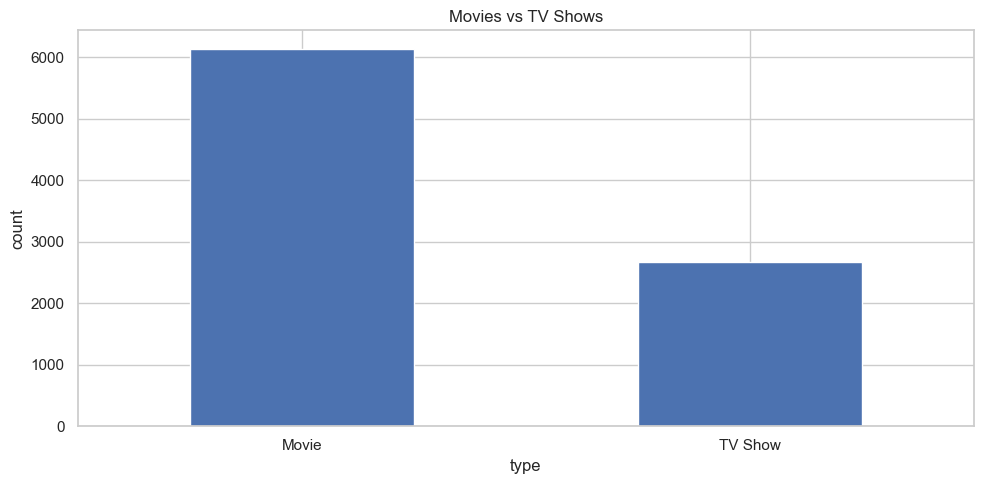

In [6]:
ax = type_counts.plot(kind="bar", rot=0)
ax.set_title("Movies vs TV Shows")
ax.set_ylabel("count")
plt.tight_layout()
plt.savefig("../images/movies_vs_tv.png", dpi=150, bbox_inches="tight")
plt.show()

## 4. Genre Analysis

In [7]:
#'listed_in' contains comma-separated genres
#split, flatten and count genres
genres_series = clean_df["listed_in"].dropna().str.split(", ")
all_genres = [genres for sublist in genres_series for genres in sublist]
genre_counts = pd.Series(all_genres).value_counts()
genre_counts.head(15)

International Movies        2752
Dramas                      2427
Comedies                    1674
International TV Shows      1351
Documentaries                869
Action & Adventure           859
TV Dramas                    763
Independent Movies           756
Children & Family Movies     641
Romantic Movies              616
TV Comedies                  581
Thrillers                    577
Crime TV Shows               470
Kids' TV                     451
Docuseries                   395
Name: count, dtype: int64

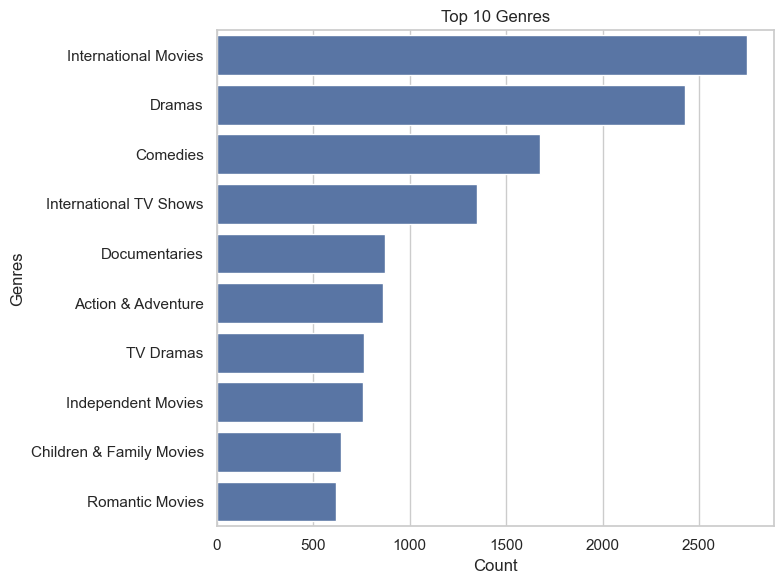

In [8]:
top_genres = genre_counts.head(10)
plt.figure(figsize=(8,6))
sns.barplot(x=top_genres.values, y=top_genres.index)
plt.title("Top 10 Genres")
plt.xlabel("Count")
plt.ylabel("Genres")
plt.tight_layout()
plt.savefig("../images/top_genres.png", dpi=150, bbox_inches="tight")
plt.show()

## 5. Country Analysis - Top producing countries
Note: many rows have multiple countries separated by commas. Will count by substring presence.

In [9]:
country_series = clean_df["country"].dropna().str.split(", ")
all_countries = [country for sublist in country_series for country in sublist]
country_counts = pd.Series(all_countries).value_counts()
country_counts.head(15)

United States     3689
India             1046
unknown            831
United Kingdom     804
Canada             445
France             393
Japan              318
Spain              232
South Korea        231
Germany            226
Mexico             169
China              162
Australia          160
Egypt              117
Turkey             113
Name: count, dtype: int64

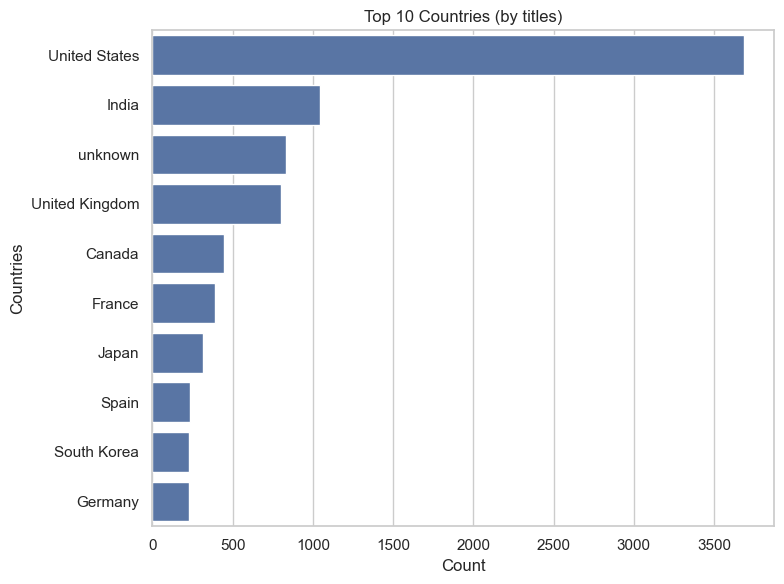

In [10]:
top_countries = country_counts.head(10)
plt.figure(figsize=(8,6))
sns.barplot(x=top_countries.values, y=top_countries.index)
plt.title("Top 10 Countries (by titles)")
plt.xlabel("Count")
plt.ylabel("Countries")
plt.tight_layout()
plt.savefig("../images/top_countries.png", dpi=150, bbox_inches="tight")
plt.show()

## 6. Release Year - Statistics & NumPy Integration
Extracting release_year as a NumPy array and compute mean, median, min, max, std.

In [11]:
years = clean_df["release_year"].to_numpy()
mean_year = np.mean(years)
median_year = np.median(years)
min_year = np.min(years)
max_year = np.max(years)
std_year = np.std(years)
mean_year, median_year, min_year, max_year, std_year

(np.float64(2014.1801975701146),
 np.float64(2017.0),
 np.int64(1925),
 np.int64(2021),
 np.float64(8.818811417623195))

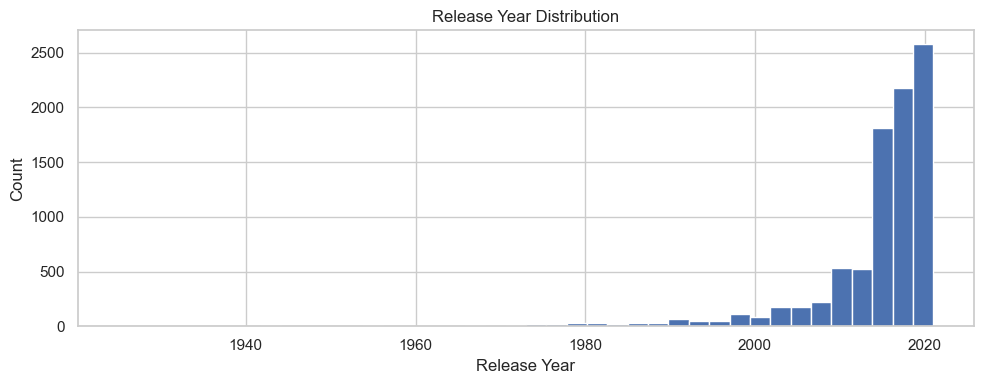

In [12]:
plt.figure(figsize=(10,4))
plt.hist(years, bins=40)
plt.title("Release Year Distribution")
plt.xlabel("Release Year")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("../images/release_year_hist.png", dpi=150, bbox_inches="tight")
plt.show()

## 7. Runtime (duration) Analysis - extract minutes
'duration' values are like "90 min" or "1 season". Will extract numeric minutes for movies.

In [13]:
#extract minutes where 'min' appears
duration = clean_df["duration"].astype(str)
mask_min = duration.str.contains("min", na=False)
minutes_series = duration[mask_min].str.extract(r"(\d+)").astype(float).iloc[:,0]
#attach to dataframe as new column (NaN for non-min entries)
clean_df.loc[mask_min, "minutes"] = minutes_series
clean_df["minutes"] = clean_df["minutes"].astype(float)
clean_df["minutes"].describe()

count    6128.000000
mean       99.577187
std        28.290593
min         3.000000
25%        87.000000
50%        98.000000
75%       114.000000
max       312.000000
Name: minutes, dtype: float64

In [14]:
#Movie-specific runtime stats
movies = clean_df[clean_df["type"] == "Movie"].copy()
movies["minutes"] = movies["duration"].str.extract(r"(\d+)").astype(float)
movies["minutes"].describe()
movies["minutes"].mean()

np.float64(99.57718668407311)

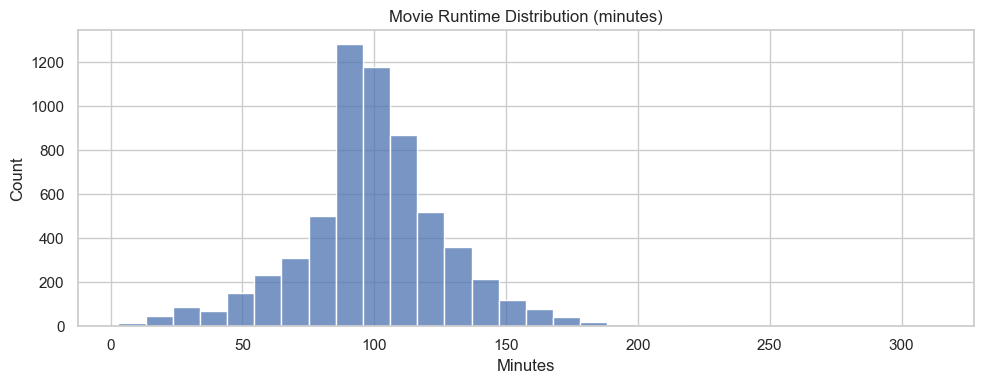

In [15]:
plt.figure(figsize=(10,4))
sns.histplot(movies["minutes"].dropna(), bins=30, kde=False)
plt.title("Movie Runtime Distribution (minutes)")
plt.xlabel("Minutes")
plt.tight_layout()
plt.savefig("../images/runtime_hist.png", dpi=150, bbox_inches="tight")
plt.show()

## 8. Ratings Distribution (Movies)
check the most common ratings for movies.

In [16]:
rating_counts = movies["rating"].fillna("Not Rated").value_counts()
rating_counts.head(15)

rating
TV-MA        2062
TV-14        1427
R             797
TV-PG         540
PG-13         490
PG            287
TV-Y7         139
TV-Y          131
TV-G          126
NR             75
G              41
TV-Y7-FV        5
NC-17           3
UR              3
Not Rated       2
Name: count, dtype: int64

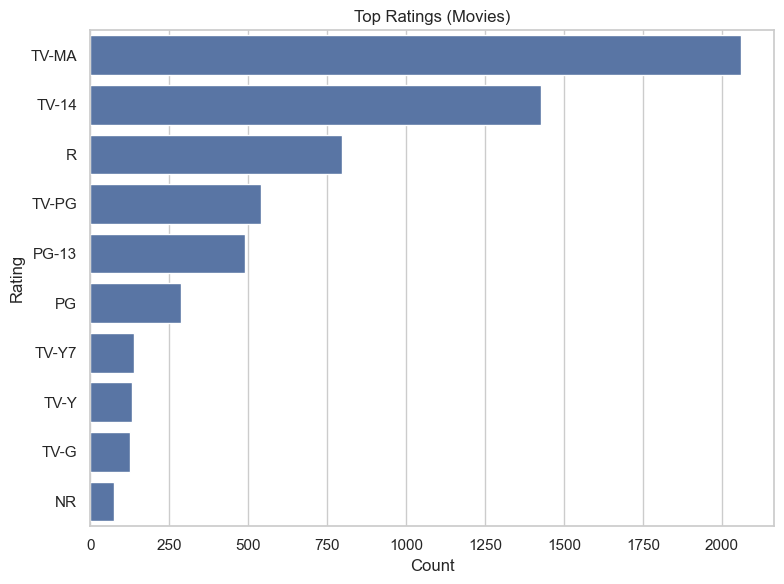

In [17]:
top_ratings = rating_counts.head(10)
plt.figure(figsize=(8,6))
sns.barplot(x=top_ratings.values, y=top_ratings.index)
plt.title("Top Ratings (Movies)")
plt.xlabel("Count")
plt.ylabel("Rating")
plt.tight_layout()
plt.savefig("../images/top_ratings.png", dpi=150, bbox_inches="tight")
plt.show()

## 9. Statistical Summary: median, IQR, outliers (release_year)

In [18]:
Q1 = clean_df["release_year"].quantile(0.25)
Q3 = clean_df["release_year"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
Q1, Q3, IQR, lower_bound, upper_bound

(np.float64(2013.0),
 np.float64(2019.0),
 np.float64(6.0),
 np.float64(2004.0),
 np.float64(2028.0))

In [19]:
outliers = clean_df[(clean_df["release_year"] < lower_bound) | (clean_df["release_year"] > upper_bound)]
print("Outliers count:", outliers.shape[0])
#sample of outliers
outliers[["title", "release_year"]].head(10)

Outliers count: 719


,title,release_year
7,Sankofa,1993
22,Avvai Shanmughi,1996
24,Jeans,1998
26,Minsara Kanavu,1997
41,Jaws,1975
42,Jaws 2,1978
43,Jaws 3,1983
44,Jaws: The Revenge,1987
48,Training Day,2001
51,InuYasha the Movie 2: The Castle Beyond the Lo...,2002


## 10. Probability Calculations
Compute:
- P(title is TV Show)
- P(title is from India)
- P(title is rated TV-MA)

In [20]:
total = len(clean_df)
p_tvshow = (clean_df["type"] == "TV Show").sum() / total
p_india = clean_df["country"].str.contains("India", na=False, case=False).sum() / total
p_tvma = (clean_df["rating"] == "TV-MA").sum() / total

print(f"P(TV Show) = {p_tvshow:.4f} ({p_tvshow*100:.2f}%)")
print(f"P(India) = {p_india:.4f} ({p_india*100:.2f}%)")
print(f"P(TV-MA) = {p_tvma:.4f} ({p_tvma*100:.2f}%)")

P(TV Show) = 0.3038 (30.38%)
P(India) = 0.1188 (11.88%)
P(TV-MA) = 0.3641 (36.41%)


## 11. Python Structures & Integration
- Tuple of unique types
- Set of unique ratings
- Summary dictionary
- Using list comprehension to extract durations in "XX min" format

In [21]:
unique_types = tuple(clean_df["type"].unique())
unique_ratings = set(clean_df["rating"].unique())
summary = {
    "total_titles": len(clean_df),
    "movies": int(clean_df["type"].value_counts().get("Movie", 0)),
    "tv_shows": int(clean_df["type"].value_counts().get("TV Show", 0))
}
runtime_list = [int(x.split()[0]) for x in clean_df["duration"].astype(str) if "min" in str(x)]
print("Unique types:", unique_types)
print("Sample ratings:", list(unique_ratings)[:10])
print("Summary:", summary)
print("Sample runtime_list (first 10):", runtime_list[:10])

Unique types: ('Movie', 'TV Show')
Sample ratings: ['66 min', 'PG-13', 'NC-17', 'TV-Y7-FV', 'R', 'NR', 'UR', 'TV-MA', 'TV-Y', 'TV-Y7']
Summary: {'total_titles': 8807, 'movies': 6131, 'tv_shows': 2676}
Sample runtime_list (first 10): [90, 91, 125, 104, 127, 91, 67, 94, 161, 61]


## 12. Advanced Optional Analysis
- Top directors
- Titles per year trend
- Genre co-occurence network

In [22]:
#Top directors (some are: NaN)
top_directors = clean_df["director"].dropna().str.split(", ").explode().value_counts().head(10)
top_years = clean_df.groupby("release_year").size().sort_index()
top_directors, top_years.tail(10)

(director
 Rajiv Chilaka          22
 Jan Suter              21
 Raúl Campos            19
 Suhas Kadav            16
 Marcus Raboy           16
 Jay Karas              15
 Cathy Garcia-Molina    13
 Jay Chapman            12
 Youssef Chahine        12
 Martin Scorsese        12
 Name: count, dtype: int64,
 release_year
 2012     237
 2013     288
 2014     352
 2015     560
 2016     902
 2017    1032
 2018    1147
 2019    1030
 2020     953
 2021     592
 dtype: int64)

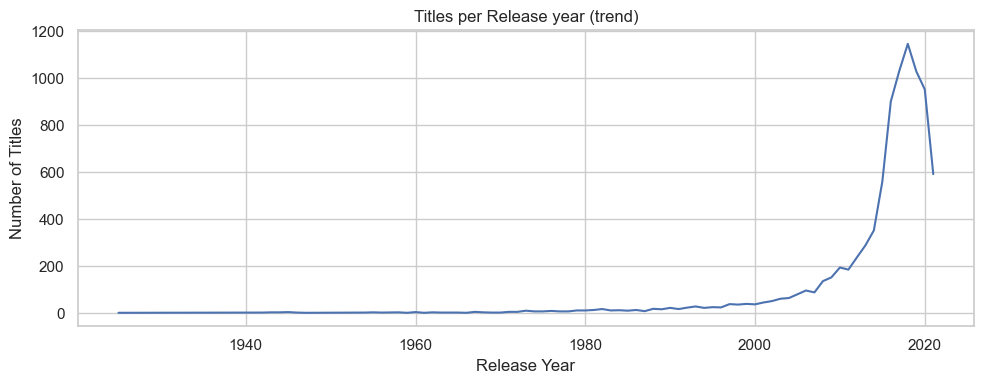

In [23]:
plt.figure(figsize=(10,4))
top_years.plot()
plt.title("Titles per Release year (trend)")
plt.xlabel("Release Year")
plt.ylabel("Number of Titles")
plt.tight_layout()
plt.savefig("../images/titles_per_year.png", dpi=150, bbox_inches="tight")
plt.show()

## 13. Conclusions and Key Insights
- Netflix catalog is modern: mean releae year ~2014, median 2017.
- Movies dominate (~70%); TV shows ~30%.
- Top genres show strong international and drama presence.
- Runtime distribution centres around ~95-100 minutes for movies.
- Ratings skew to mature audiences (TV-MA, TV-14).
- Outliers (older content) exist but account for a small portion (~8%).

In [24]:
#save cleaned dataframe for future use
clean_df.to_csv("../data/netflix_cleaned.csv", index=False)

#save summary to JSON for quick API or README usage
import json
with open("../data/summary.json", "w") as f:
    json.dump(summary, f, indent=2)
print("Saved cleaned data and summary.")

Saved cleaned data and summary.


## Future Work
- Build interactive dashboard (Streamlit) to explore genres and filters.
- Perform NLP on titles/descriptions to find themes.
- Build a recommender using content-based features (genres, director, cast).
- Time-series analysis on 'date_added' for publishing trends.